# Advanced Predictive Model | BAIS:6100

**Instructor: Qihang Lin**

## Sparse Linear Model -- A Quick Review

A spare linear model with a given $C$ can be trained and tested as follows.

In [1]:
#Load the data for this example
import pandas as pd
import re
df = pd.read_csv("classdata/Lies_and_Truths.csv")
df = df[df.Domain=="Electronics"].copy()
df.reset_index(drop=True, inplace=True)
df = df[["Sentiment Polarity","Review"]]   #Keep only the columns we need.

In [2]:
#Split the data
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.33, random_state=2021)
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

In [3]:
#Feature Engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk 

stemmer = nltk.stem.SnowballStemmer("english")
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

nltk_stopwords = nltk.corpus.stopwords.words("english") 

vectorizer=StemmedTfidfVectorizer(stop_words=nltk_stopwords, norm=None)

#Create the training and testing DTMs and the labels
train_x = vectorizer.fit_transform(df_train["Review"])
train_y = df_train["Sentiment Polarity"]
test_x = vectorizer.transform(df_test["Review"])
test_y = df_test["Sentiment Polarity"]

In [16]:
#Model training
from sklearn.linear_model import LogisticRegression
sparselr = LogisticRegression(penalty='l1', 
                              solver='liblinear',
                              random_state=2021,
                              tol=0.001,
                              max_iter=1000, 
                              C=1)
sparselr.fit(train_x,train_y)

LogisticRegression(C=1, max_iter=1000, penalty='l1', random_state=2021,
                   solver='liblinear', tol=0.001)

In [17]:
#How many non-zero betas in total (Sparsity)
sum(sparselr.coef_[0]!=0)

252

In [18]:
#Performance evaluation
from sklearn.metrics import accuracy_score, roc_auc_score
print("Train Accuracy:")
print(accuracy_score(train_y,sparselr.predict(train_x)))
print("Test Accuracy:")
print(accuracy_score(test_y,sparselr.predict(test_x)))
print("Train AUC:")
print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:, 1]))
print("Test AUC:")
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))

Train Accuracy:
0.998109640831758
Test Accuracy:
0.8352490421455939
Train AUC:
0.9999928473334859
Test AUC:
0.9159688642528601


Change $C$ to 100000 and to $0.0001$ and run the codes above. How does the sparsity level change? How does the performance change?

## What Affect a Model's Performance

The performance of a predictive model depends on 

* The hyper-parameter, for example, $C$. 
* How the DTM is constructed (feature engineering). 
* solver, tol and max_iter. 

To improve the performance, we need to carefully tune the hyper-parameters and try different DTMs.

## Cross Validation

In practice, the regularization parameter $C$ can be tuned using **$K$-fold cross validation** (typically $K=5$). This technique can be used to select any hyper-parameter in any model. 

<img src=http://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png width="500">

1. Generate a list of candidate values for $C$


2. For each candidate, do the following:

    - Split the training dataset into $K$ groups
    - For each unique group:

        1. Take the group as a validation set
        2. Take the remaining groups as a training set
        3. Fit a model on the training set and evaluate it on the validation set
        4. Retain the performance score and discard the model

    - Summarize the model's performance using the average of $K$ performance scores.


3. Repeat this procedure for each candidate value of $C$ and select the value with the best performance.

## Grid Search

Searching for the optimal $C$ precisely is very hard. In reality, depending on the runtime, we can only try around 5~30 different candidates, called **a grid of parameters**. 

Unless we have a good estimation of the range of $C$, the common practice is to create a grid covering numbers in different scales, for example, 1, 10, 100, 1000. This can be done by generating the candidates that increase proportionally instead of additively.

In [19]:
#Generate the grid of parameters that increase proportionally.
import numpy as np
from sklearn.svm import l1_min_c
param_grid = l1_min_c(train_x, train_y, loss='log') * np.logspace(start=0, stop=5, num=20) 
param_grid

array([7.13795364e-03, 1.30837313e-02, 2.39822272e-02, 4.39589598e-02,
       8.05759254e-02, 1.47694117e-01, 2.70720468e-01, 4.96225395e-01,
       9.09571578e-01, 1.66722716e+00, 3.05599522e+00, 5.60158029e+00,
       1.02675886e+01, 1.88202919e+01, 3.44972320e+01, 6.32327608e+01,
       1.15904431e+02, 2.12450586e+02, 3.89417826e+02, 7.13795364e+02])

*   **l1_min_c** finds the smallest $C$ that makes the model "empty", i.e., all $\beta$'s become zero. Any $C$ smaller than **l1_min_c** will not be interesting.

*  **np.logspace(start=0, stop=5, num=20)**  generates 20 numbers that increase proportionally from $10^{0}=1$ to $10^{5}$. They are multiplied to **l1_min_c** to proportionally increase $C$ from **l1_min_c** to **l1_min_c$\times 10^{5}$**.

## Implementation

In [20]:
from sklearn.linear_model import LogisticRegressionCV
sparselr = LogisticRegressionCV(penalty='l1', 
                                solver='liblinear', 
                                Cs=param_grid,   #Use the grid generated above
                                cv=5,            #Number of folds, that is, K
                                scoring='accuracy', #The performance metric to select the best C.
                                random_state=2021,  #To make sure the result is reproducible
                                tol=0.001,
                                max_iter=1000)
sparselr.fit(train_x, train_y)

LogisticRegressionCV(Cs=array([7.13795364e-03, 1.30837313e-02, 2.39822272e-02, 4.39589598e-02,
       8.05759254e-02, 1.47694117e-01, 2.70720468e-01, 4.96225395e-01,
       9.09571578e-01, 1.66722716e+00, 3.05599522e+00, 5.60158029e+00,
       1.02675886e+01, 1.88202919e+01, 3.44972320e+01, 6.32327608e+01,
       1.15904431e+02, 2.12450586e+02, 3.89417826e+02, 7.13795364e+02]),
                     cv=5, max_iter=1000, penalty='l1', random_state=2021,
                     scoring='accuracy', solver='liblinear', tol=0.001)

To use AUC as the performance metric, set **scoring='roc_auc'**

More performance metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

More options: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html

Searching in a large grid needs a long runtime. To speed up, we may have to reduce **stop** or **num** in **np.logspace** or reduce **cv**. 

In [21]:
#All candicates
sparselr.Cs_

array([7.13795364e-03, 1.30837313e-02, 2.39822272e-02, 4.39589598e-02,
       8.05759254e-02, 1.47694117e-01, 2.70720468e-01, 4.96225395e-01,
       9.09571578e-01, 1.66722716e+00, 3.05599522e+00, 5.60158029e+00,
       1.02675886e+01, 1.88202919e+01, 3.44972320e+01, 6.32327608e+01,
       1.15904431e+02, 2.12450586e+02, 3.89417826e+02, 7.13795364e+02])

In [22]:
#This is the best value of C among the candidates.
sparselr.C_

array([34.497232])

In [23]:
#The performance score for each C in K folds.
pd.DataFrame(sparselr.scores_["pos"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.518868,0.650943,0.783019,0.820755,0.801887,0.792453,0.783019,0.792453,0.792453,0.792453,0.764151,0.792453,0.830189,0.830189,0.839623,0.764151,0.764151,0.716981,0.745283,0.754717
1,0.518868,0.698113,0.783019,0.773585,0.754717,0.754717,0.830189,0.849057,0.839623,0.839623,0.849057,0.877358,0.877358,0.858491,0.896226,0.877358,0.877358,0.792453,0.764151,0.764151
2,0.509434,0.650943,0.792453,0.830189,0.830189,0.839623,0.849057,0.839623,0.839623,0.849057,0.839623,0.820755,0.792453,0.811321,0.801887,0.764151,0.792453,0.754717,0.735849,0.688679
3,0.509434,0.641509,0.801887,0.820755,0.811321,0.830189,0.820755,0.839623,0.830189,0.849057,0.839623,0.830189,0.820755,0.830189,0.811321,0.849057,0.839623,0.839623,0.792453,0.830189
4,0.514286,0.628571,0.800000,0.809524,0.828571,0.828571,0.828571,0.838095,0.828571,0.847619,0.828571,0.857143,0.819048,0.828571,0.847619,0.809524,0.761905,0.733333,0.780952,0.761905


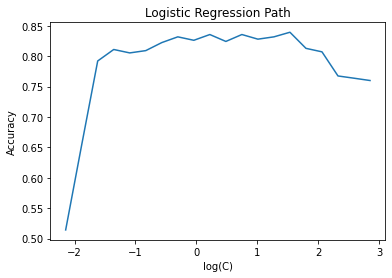

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log10(sparselr.Cs_), sparselr.scores_["pos"].mean(axis=0))
plt.xlabel('log(C)')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

After running **sparselr.fit**, **sparselr** has already been **retrained** the best $C$ from the grid.

Let's evaluate the performance using the best $C$.

In [25]:
print("Train Accuracy:")
print(accuracy_score(train_y,sparselr.predict(train_x)))
print("Test Accuracy:")
print(accuracy_score(test_y,sparselr.predict(test_x)))
print("Train AUC:")
print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:, 1]))
print("Test AUC:")
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))

Train Accuracy:
0.998109640831758
Test Accuracy:
0.8352490421455939
Train AUC:
0.9999928473334859
Test AUC:
0.9239297086920628


##  Tuning a DTM

In addition to the regularization parameter $C$, the choices we made in the stages of dataset preparation and feature engineering can also affect the DTM, and thus, the performance of a predictive model.
    
   - Stemming or not
   - Remove stop words or not
   - Unigram or N-gram
   - TF, TFIDF, or Binary
   - Unnormalized or normalized
   - All unique terms or just top-$K$ terms

Next, we build a SLR based on a DTM in TF and compare with the previous model in their AUC and Accuracy values on the testing set.

In [26]:
stemmer = nltk.stem.SnowballStemmer("english")
nltk_stopwords = nltk.corpus.stopwords.words("english") 

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [27]:
vectorizer=StemmedCountVectorizer(stop_words=nltk_stopwords)
train_x = vectorizer.fit_transform(df_train["Review"])
train_y = df_train["Sentiment Polarity"]
test_x = vectorizer.transform(df_test["Review"])
test_y = df_test["Sentiment Polarity"]

Note that, when we change DTM, **l1_min_c** must be recalculated. So must **param_grid**.

In [28]:
param_grid = l1_min_c(train_x, train_y, loss='log') * np.logspace(start=0, stop=5, num=20) 
sparselr = LogisticRegressionCV(penalty='l1', 
                                solver='liblinear', 
                                Cs=param_grid,   
                                cv=5,            
                                scoring='accuracy', 
                                random_state=2021,  
                                tol=0.001,
                                max_iter=1000)
sparselr.fit(train_x, train_y)
print("Train Accuracy:")
print(accuracy_score(train_y,sparselr.predict(train_x)))
print("Test Accuracy:")
print(accuracy_score(test_y,sparselr.predict(test_x)))
print("Train AUC:")
print(roc_auc_score(train_y,sparselr.predict_proba(train_x)[:, 1]))
print("Test AUC:")
print(roc_auc_score(test_y,sparselr.predict_proba(test_x)[:, 1]))

Train Accuracy:
0.998109640831758
Test Accuracy:
0.8390804597701149
Train AUC:
0.9999928473334859
Test AUC:
0.9255808467979715


It seems TFIDF words better than TF in this example. 

**More comparisons**



| Score | Stemming | N-Gram | Accuracy | AUC |
| --- | --- | --- | --- | --- |
| Unnormalized Tfidf | Yes | Unigram | 0.84 | 0.92 |
| Normalized Tfidf | Yes | Unigram | 0.83 | 0.92 |
| TF | Yes | Unigram | 0.84 | 0.93 |
| TF | No | Bigram | 0.58 | 0.58 |
| Binary | Yes | Unigram | 0.86 | 0.93 |
| Binary | No | Bigram | 0.64 | 0.72 |

## Decision Tree: A Rule-Based Predictive Model

* Using "decision rules" to predict the outcome an event.
* For example:
    - "A senior student with a high income and an excellent credit-rating will buy a computer from our store."
    - "A debtor with age <=25 and debt-to-income ratio>80% will default."
    - "An IT help desk ticket containing the term”account" is about an issue of login."

* The collection of rules can be represented by a tree diagram
    * Example: Predict if someone will cheat on their income tax return based on their marital status, tax income, and whether they are due a tax refund. See the tree below:

<img src="https://raw.githubusercontent.com/alexeygrigorev/wiki-figures/master/ufrt/kddm/decision-tree-ex2.png" width="400">

The **depth** of a tree is the length of the longest path from the **root node** to a **leaf node**.
   - The depth of the tree above is three.
   - A deision tree with too many leaves and a large depth is very likely to be overfitted. 

## A Gentle Introduction to XGBoost

XGBoost is short for "eXtreme Gradient Boosting", which is an **ensemble model**. 
- An ensemble model combines different machine learning models (e.g., decision trees) into one and performs better than individual models. 
- It is created by the following procedure:
    - Learn the first tree from data to minmize the training error. This model usually has a large error.
    - Learn the second tree from a random subset to correct the error made by the first tree. 
    - Learn the third tree from another random subset to correct the error made by the first and second trees.
    - The algorithm repeats this procedure until it builds a decent quality mode.
    
- Eventually, XGBosst makes the prediction by taking the weighted average of the predictions made by all trees.

<img src="
https://www.researchgate.net/profile/Mahsa-Shoaran/publication/325632132/figure/fig2/AS:639244859093006@1529419259793/Schematic-diagram-of-a-boosted-ensemble-of-decision-trees.png" width="500">

- The "eXtreme" refers to speed enhancements such as parallel computing and cache awareness that makes XGBoost approximately 10 times faster than traditional Gradient Boosting. 

XGBoost's popularity surged because:
   - It consistently outperformed comparable machine learning algorithms when making predictions from tabular data (structured data). 
   - First-prize winner in many Kaggle competitions. 
   - Hard to get overfitted.
   - Very fast.
   - Easy to implement in scikit-learn.

A book on XGBoost: 
https://www.amazon.com/Hands-Gradient-Boosting-XGBoost-scikit-learn-ebook/dp/B08GSSGTYF

## Model Training

A library for xgboost that provides sklearn API:

In [30]:
#!pip3 install xgboost
from xgboost import XGBClassifier

In [31]:
xgb=XGBClassifier(n_estimators=200,    #How many trees in total
                  max_depth=5,         #The depth of each tree
                  nthread=4,           #Multi-thread speed up
                  use_label_encoder=False,  #To avoid an unimportant warning message 
                  verbosity = 0,       #Hidden other messages during training
                  random_state=2021)   #Fix the results of random sampling during training

More options can be found:
https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

**XGBClassifier** require numeric class labels (e.g., 0=neg and 1=pos) so we need to encode the labels first. By default, the alphabetically last label will be encoded into 1 and the other label will become 0. 

In [32]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train_y=le.fit_transform(train_y)
test_y=le.transform(test_y)

In [33]:
xgb.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=2021, reg_alpha=0, ...)

## Descriptive Analytics (XGBoost)

Gradient boosting calculates an importance score for each term that indicates how useful that term was in the construction of the decision trees within the model. 

The more useful a term is in making a prediction, the higher its importance is.

In [34]:
#Importance score
xgb.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [35]:
dfbeta = pd.DataFrame({'Term': vectorizer.get_feature_names(),
                       'Importance': xgb.feature_importances_
                     })
dfbeta.sort_values(by="Importance",inplace=True,ascending=False)
dfbeta.reset_index(inplace=True,drop=True)
dfbeta.head(10)

/home/abromeland/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Term,Importance
0,sleek,0.039415
1,fantast,0.037282
2,love,0.033920
3,perfect,0.029883
4,amaz,0.025804
5,start,0.023955
6,disappoint,0.021148
7,built,0.020613
8,allow,0.018195
9,wast,0.017326


Compared to $\beta$'s in sparse logistic regression, importance score does not distinguish terms with positive and negative impact. 

## Predictive Analytics  (XGBoost)

Predictions by XGBoost are implemented in a way similar to SLR.

In [36]:
#Apply the model to the reviews testing set and predict the classes
xgb.predict(test_x)[0:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0])

In [37]:
#Predict the probability in each class (in alphabetical order of the classes)
xgb.predict_proba(test_x)[0:10]

array([[9.9743140e-01, 2.5685935e-03],
       [9.8153418e-01, 1.8465804e-02],
       [1.6362548e-01, 8.3637452e-01],
       [9.8455006e-01, 1.5449947e-02],
       [8.1260675e-01, 1.8739323e-01],
       [7.3560524e-01, 2.6439476e-01],
       [9.7903705e-01, 2.0962974e-02],
       [7.1437037e-01, 2.8562966e-01],
       [8.0102682e-04, 9.9919897e-01],
       [6.4550185e-01, 3.5449812e-01]], dtype=float32)

In [38]:
print("Train Accuracy:")
print(accuracy_score(train_y,xgb.predict(train_x)))
print("Test Accuracy:")
print(accuracy_score(test_y,xgb.predict(test_x)))
print("Train AUC:")
print(roc_auc_score(train_y,xgb.predict_proba(train_x)[:, 1]))
print("Test AUC:")
print(roc_auc_score(test_y,xgb.predict_proba(test_x)[:, 1]))

Train Accuracy:
0.996219281663516
Test Accuracy:
0.8314176245210728
Train AUC:
0.9999713893339437
Test AUC:
0.8897275622125251


## Cross Validation (XGBoost)

The performance of XGBoost depends on many tuning parameters:
   - max_depth: typically between 2 and 20
   - n_estimators: typically between 100 and 500
   - Others

In sklearn, parameters in XGBoost can be selected by $K$-fold cross validation using **GridSearchCV**.

In [39]:
from sklearn.model_selection import GridSearchCV   
param_list = {  
 'max_depth':[2, 5],       #Candidate for max_depth
 'n_estimators':[10, 100]  #Candidate for n_estimators
}
xgb=XGBClassifier(nthread=4,
                  use_label_encoder=False,
                  verbosity = 0,
                  random_state=2021
                 )
xgb = GridSearchCV(estimator = xgb, 
                   param_grid = param_list,
                   scoring = 'accuracy',  #The performance metric to select the best parameters.
                   cv=5                   #Number of folds, i.e., K
                  )  
xgb.fit(train_x, train_y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=2021, reg_alpha=None, ...),
             param_grid={'max_depth': [2, 5], 'n_estimators': [10, 100]},
             scoring='accuracy')

In [40]:
#The averaged performance for each combination of parameters.
pd.DataFrame(xgb.cv_results_)[["param_max_depth","param_n_estimators","mean_test_score"]]

,param_max_depth,param_n_estimators,mean_test_score
0,2,10,0.761815
1,2,100,0.831788
2,5,10,0.812902
3,5,100,0.795885


In [41]:
#This is the best combination of parameters.
xgb.best_params_

{'max_depth': 2, 'n_estimators': 100}

Evaluate the performance using the best parameters.

In [45]:
print("Train Accuracy:")
print(accuracy_score(train_y,xgb.predict(train_x)))
print("Test Accuracy:")
print(accuracy_score(test_y,xgb.predict(test_x)))
print("Train AUC:")
print(roc_auc_score(train_y,xgb.predict_proba(train_x)[:, 1]))
print("Test AUC:")
print(roc_auc_score(test_y,xgb.predict_proba(test_x)[:, 1]))

Train Accuracy:
0.9697542533081286
Test Accuracy:
0.8352490421455939
Train AUC:
0.9962734607461662
Test AUC:
0.9108975114989976


Similarly, we can further improve the performance of XGBoost by using different DTMs. Since the procedure is identical to that of SLR, we omit the details. 

XBG library does not do re-train. Hence, after knowing the best parameters from cross validation, we need to use them to build a final XGB model (re-train by ourselves). See below:

In [43]:
xgb=XGBClassifier(max_depth=2,
                  n_estimators=100,
                  nthread=4,
                  use_label_encoder=False,
                  verbosity = 0,
                  random_state=2021
                 )
xgb.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=2021, reg_alpha=0, ...)

In [44]:
dfbeta = pd.DataFrame({'Term': vectorizer.get_feature_names(),
                       'Importance': xgb.feature_importances_
                     })
dfbeta.sort_values(by="Importance",inplace=True,ascending=False)
dfbeta.reset_index(inplace=True,drop=True)
dfbeta.head(10)

/home/abromeland/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Term,Importance
0,love,0.057615
1,best,0.038459
2,easi,0.038394
3,perfect,0.038254
4,amaz,0.028104
5,great,0.026452
6,high,0.020725
7,end,0.019928
8,sleek,0.019905
9,disappoint,0.018073
